In [303]:
!pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe8

In [2]:
# important imports
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt 
import random
import time

In [3]:
# constants
mu_friction = .5 # friction of ground on ball, based on value from the simulator https://github.com/RoboCup-SSL/grSim/blob/master/src/physics/pworld.cpp
r_ball = 0.021335 # radius of golfball in m
m_ball = 0.04593 # weight of golfball in kg
gravity = 9.81 # gravitational constant in m/s^2
constant_constant = mu_friction*r_ball*m_ball*gravity # mu*m*g*r
print(constant_constant)

def calculate_trajectory():
    dt = .01
    x = 0
    y = 0
    v = np.array([0,1,0])
    w = np.array([1000.0,0,0])
    n = 10
    data = []
    while n > 5:
        v_cur = v + np.cross(w,np.array([0,0,-r_ball]))
        x += v_cur[0]*dt
        y += v_cur[1]*dt
        inertia_multiplier = constant_constant/np.sqrt((v_cur[0]+r_ball*w[1])**2+(v_cur[1]-r_ball*w[0])**2)
        w[0] += inertia_multiplier*(v_cur[0]+r_ball*w[1])*dt
        w[1] += -inertia_multiplier*(v_cur[1]-r_ball*w[0])*dt
#         print(v_cur)
        print(w)
        print(x,y)
        v = v_cur
        n-=1

def generate_data():
    v_kick_vals = np.linspace(.5,8,76) # kicker initial speed values in m/s
    w_dribbler_vals = np.linspace(0,12000,41) # dribbler rotational angle in rad/s
    theta_angle_vals = np.linspace(0,360,361) # angle between center of mass velocity and x-coordinate of reference system, in degrees 
    
    data = [] # generated data based on all the initial paramaters
    
    for v in v_kick_vals:
        for w in w_dribbler_vals:
            for theta in theta_angle_vals:
                V_com_vec = v*np.array([np.cos(theta),np.sin(theta),0]) # equation (1)
#                 w_vec = [_,_,0] # equation (2) not 100% sure what w_x and w_y are
                w_vec = w*np.array([np.cos(theta),np.sin(theta),0]) # equation (2) not 100% sure what w_x and w_y are, I think rotation should do the trick
                V_cp_vec = V_com_vec+np.cross(w_vec,[0,0,-r_ball]) # equation (3)

#                 F_fric_vec = mu_friction*m_ball*gravity*(-V_cp_vec/np.sqrt(np.dot(V_cp_vec,V_cp_vec))) # equation (4)
#                 T_fric_vec = np.cross(F_fric_vec, [0,0,-r_ball]) # equation (5)
                print(V_com_vec)
                inertia_multiplier = constant_constant/np.sqrt((V_cp_vec[0]+r_ball*w_vec[1])**2+(V_cp_vec[1]-r_ball*w_vec[0])**2)
                inertia = inertia_multiplier*np.array([V_cp_vec[0]+r_ball*w_vec[1],V_cp_vec[1]-r_ball*w_vec[0],0])
                print(inertia)


                

0.004806490677749999


In [49]:
import numpy as np
from scipy.integrate import solve_ivp

def golf_ball_trajectory(t, y, m, r, mu, g, I):
    """
    Define the ODE system for the golf ball trajectory.

    Parameters:
    - t: Current time
    - y: State vector [x, y, theta, Vx, Vy, omega_x, omega_y]
    - m: Mass of the ball
    - r: Radius of the ball
    - mu: Coefficient of friction
    - g: Acceleration due to gravity
    - I: Moment of inertia

    Returns:
    - dydt: Derivatives of the state vector
    """
    x, y, theta, Vx, Vy, omega_x, omega_y = y

    V_COM = np.sqrt(Vx**2 + Vy**2)
    V_CP_x = V_COM * np.cos(theta) - r * omega_y
    V_CP_y = V_COM * np.sin(theta) + r * omega_x

    F_fric_x = -mu * m * g * (V_CP_x + r * omega_y) / np.sqrt((V_CP_x + r * omega_y)**2 + (V_CP_y - r * omega_x)**2)
    F_fric_y = -mu * m * g * (V_CP_y - r * omega_x) / np.sqrt((V_CP_x + r * omega_y)**2 + (V_CP_y - r * omega_x)**2)

    T_Ffric = -r * (F_fric_y * np.cos(theta) - F_fric_x * np.sin(theta))

    dydt = [
        Vx,
        Vy,
        (omega_x * np.sin(theta) + omega_y * np.cos(theta)) / V_COM,
        (F_fric_x + m * g * np.sin(theta)) / m,
        (F_fric_y - m * g * np.cos(theta)) / m,
        (T_Ffric / I) * np.sin(theta),
        -(T_Ffric / I) * np.cos(theta)
    ]

    return dydt

def solve_golf_ball_trajectory(m, r, mu, g, I, V_kick, omega_dribbler, theta, t_span):
    """
    Solve the golf ball trajectory ODE using scipy's solve_ivp.

    Parameters:
    - m: Mass of the ball
    - r: Radius of the ball
    - mu: Coefficient of friction
    - g: Acceleration due to gravity
    - I: Moment of inertia
    - V_kick: Initial speed of the ball
    - omega_dribbler: Initial angular velocity of the ball
    - theta: Initial angle
    - t_span: Time span for integration [t_start, t_end]

    Returns:
    - sol: Solution object from solve_ivp
    """
    initial_conditions = [0, 0, theta, V_kick * np.cos(theta), V_kick * np.sin(theta), omega_dribbler, 0]
    sol = solve_ivp(
        fun=lambda t, y: golf_ball_trajectory(t, y, m, r, mu, g, I),
        t_span=t_span,
        y0=initial_conditions,
        method='RK45',
        dense_output=True
    )
    return sol

# Example usage:
m = 0.045  # Mass of the golf ball
r = 0.021  # Radius of the golf ball
mu = 0.3   # Coefficient of friction
g = 9.8    # Acceleration due to gravity
I = 2 / 3 * m * r**2  # Moment of inertia for a solid sphere

V_kick = 10  # Initial speed of the ball
omega_dribbler = 0.5  # Initial angular velocity of the ball
theta = np.pi / 4  # Initial angle

t_span = [0, 5]  # Time span for integration

sol = solve_golf_ball_trajectory(m, r, mu, g, I, V_kick, omega_dribbler, theta, t_span)

# Access the solution at specific time points
t_points = np.linspace(t_span[0], t_span[1], 100)
solution_at_t_points = sol.sol(t_points)
print(solution_at_t_points)

[[ 0.00000000e+00  3.63318051e-01  7.39050599e-01  1.12723953e+00
   1.52792713e+00  1.94114993e+00  2.36692859e+00  2.80530909e+00
   3.25633930e+00  3.72006611e+00  4.19653549e+00  4.68579245e+00
   5.18788106e+00  5.70284442e+00  6.23072471e+00  6.77156314e+00
   7.32539999e+00  7.89227458e+00  8.47222527e+00  9.06528951e+00
   9.67150376e+00  1.02909035e+01  1.09235235e+01  1.15693971e+01
   1.22285572e+01  1.29010355e+01  1.35868628e+01  1.42860688e+01
   1.49986826e+01  1.57247320e+01  1.64642440e+01  1.72172447e+01
   1.79837591e+01  1.87638115e+01  1.95574250e+01  2.03646219e+01
   2.11854235e+01  2.20198501e+01  2.28679212e+01  2.37296551e+01
   2.46050695e+01  2.54941809e+01  2.63970049e+01  2.73135561e+01
   2.82438483e+01  2.91879175e+01  3.01457987e+01  3.11175082e+01
   3.21030620e+01  3.31024762e+01  3.41157665e+01  3.51429487e+01
   3.61840381e+01  3.72390501e+01  3.83079999e+01  3.93909024e+01
   4.04877725e+01  4.15986249e+01  4.27234740e+01  4.38623342e+01
   4.50152

In [48]:
calculate_trajectory()

[ 1.00000000e+03 -4.80649068e-05  0.00000000e+00]
0.0 0.22335000000000002
[ 1.00000000e+03 -9.61298136e-05  0.00000000e+00]
1.0254647860979624e-08 0.66005
[ 1.0000000e+03 -1.4419472e-04  0.0000000e+00]
4.1018591443918497e-08 1.3101
[ 1.00000000e+03 -1.92259627e-04  0.00000000e+00]
1.0254647860979625e-07 2.1735
[ 1.00000000e+03 -2.40324534e-04  0.00000000e+00]
2.0509295721959247e-07 3.250250000000001


# Pool ball physics
This section tries to implement the formulas mentioned on this website: https://ekiefl.github.io/2020/04/24/pooltool-theory/#--case-3-rolling.

In [4]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

# Taken from https://billiards.colostate.edu/faq/physics/physical-properties/
g = 9.8 # gravitational constant
m = 0.04593 # ball mass
R = 0.021335 # ball radius
u_s = 0.2 # sliding friction
u_r = 0.01 # rolling friction
u_sp = 10 * 2/5*R/9 # spinning friction

# Ball states
stationary=0
spinning=1
sliding=2
rolling=3

state_dict = {
    0: 'stationary',
    1: 'spinning',
    2: 'sliding',
    3: 'rolling',
}

#tol = np.finfo(np.float).eps * 100
tol = 1e-12

In [6]:
# from panda3d.core import *

def get_list_of_Vec3s_from_array(array):
    """array is shape (N, 3)"""
    vec3s = []
    for i in range(array.shape[0]):
        vec3s.append(Vec3(*array[i,:]))

    return vec3s


def get_quaternion_list_from_array(array):
    """array is shape (N, 4)"""
    quats = []
    for i in range(array.shape[0]):
        quats.append(get_quat_from_vector(array[i,:]))

    return quats


def get_quat_from_vector(v, normalize=True):
    """Get Quat object from 4-d vector"""
    quat = Quat(Vec4(*v))

    if normalize:
        quat.normalize()

    return quat


def normalize(*args):
    myVec = LVector3(*args)
    myVec.normalize()
    return myVec


def make_rectangle(x1, y1, z1, x2, y2, z2, name='rectangle'):
    fmt = GeomVertexFormat.getV3n3cpt2()
    vdata = GeomVertexData('rectangle', fmt, Geom.UHDynamic)

    vertex = GeomVertexWriter(vdata, 'vertex')
    normal = GeomVertexWriter(vdata, 'normal')
    #texcoord = GeomVertexWriter(vdata, 'texcoord')

    # make sure we draw the sqaure in the right plane
    if x1 != x2:
        vertex.addData3(x1, y1, z1)
        vertex.addData3(x2, y1, z1)
        vertex.addData3(x2, y2, z2)
        vertex.addData3(x1, y2, z2)

        # FIXME calculate the norm
        normal.addData3(normalize(0,0,1))
        normal.addData3(normalize(0,0,1))
        normal.addData3(normalize(0,0,1))
        normal.addData3(normalize(0,0,1))

    else:
        vertex.addData3(x1, y1, z1)
        vertex.addData3(x2, y2, z1)
        vertex.addData3(x2, y2, z2)
        vertex.addData3(x1, y1, z2)

        # FIXME calculate the norm
        normal.addData3(normalize(0,0,1))
        normal.addData3(normalize(0,0,1))
        normal.addData3(normalize(0,0,1))
        normal.addData3(normalize(0,0,1))

    # FIXME calculate with a scale or something
    #scale = 1
    #texcoord.addData2f(0.0, scale)
    #texcoord.addData2f(0.0, 0.0)
    #texcoord.addData2f(scale, 0.0)
    #texcoord.addData2f(scale, scale)

    tris = GeomTriangles(Geom.UHDynamic)
    tris.addVertices(0, 1, 3)
    tris.addVertices(1, 2, 3)

    rectangle = Geom(vdata)
    rectangle.addPrimitive(tris)
    rectangle_node = GeomNode(name)
    rectangle_node.addGeom(rectangle)

    return rectangle_node

In [7]:
class Ball(object):
    def __init__(self, ball_id, m=None, R=None):
        self.id = ball_id

        # physical properties
        self.m = m or psim.m
        self.R = R or psim.R
        self.I = 2/5 * self.m * self.R**2

        self.rvw = np.array([[np.nan, np.nan, np.nan],  # positions (r)
                             [0,      0,      0     ],  # velocities (v)
                             [0,      0,      0     ],  # angular velocities (w)
                             [0,      0,      0     ]]) # angular integrations (e)

        # stationary=0, spinning=1, sliding=2, rolling=3
        self.s = 0


    def __repr__(self):
        lines = [
            f'<{self.__class__.__module__}.{self.__class__.__name__} object at {hex(id(self))}>',
            f' ├── id       : {self.id}',
            f' ├── state    : {self.s}',
            f' ├── position : {self.rvw[0]}',
            f' ├── velocity : {self.rvw[1]}',
            f' ├── angular  : {self.rvw[2]}',
            f' └── euler    : {self.rvw[3]}',
        ]

        return '\n'.join(lines) + '\n'


    def set(self, rvw, s):
        self.s = s
        self.rvw = rvw

In [23]:
#! /usr/bin/env python

import os
import cmath
import psutil
import numpy as np

from numba import njit
from scipy.spatial.transform import Rotation
# from pyquaternion import Quaternion


def get_total_memory_usage(keep_raw=False):
    """Get the total memory, including children

    Parameters
    ==========
    keep_raw : bool, False
        A human readable format is returned, e.g. "1.41 GB". If keep_raw, the raw number is
        returned, e.g. 1515601920
    """
    current_process = psutil.Process(os.getpid())
    mem = current_process.memory_info().rss
    for child in current_process.children(recursive=True):
        try:
            mem += child.memory_info().rss
        except:
            pass

    return mem if keep_raw else human_readable_file_size(mem)


def display_top_memory_usage(snapshot, key_type='lineno', limit=10):
    """A pretty-print for the tracemalloc memory usage module

    Modified from https://docs.python.org/3/library/tracemalloc.html

    Examples
    ========
    >>> import tracemalloc
    >>> import anvio.utils as utils
    >>> tracemalloc.start()
    >>> snap = tracemalloc.take_snapshot
    >>> utils.display_top_memory_usage(snap)
    Top 10 lines
    #1: anvio/bamops.py:160: 4671.3 KiB
        constants.cigar_consumption,
    #2: anvio/bamops.py:96: 2571.6 KiB
        self.cigartuples = np.array(read.cigartuples)
    #3: python3.6/linecache.py:137: 1100.0 KiB
        lines = fp.readlines()
    #4: <frozen importlib._bootstrap_external>:487: 961.4 KiB
    #5: typing/templates.py:627: 334.3 KiB
        return type(base)(name, (base,), dct)
    #6: typing/templates.py:923: 315.7 KiB
        class Template(cls):
    #7: python3.6/_weakrefset.py:84: 225.2 KiB
        self.data.add(ref(item, self._remove))
    #8: targets/npyimpl.py:411: 143.2 KiB
        class _KernelImpl(_Kernel):
    #9: _vendor/pyparsing.py:3349: 139.7 KiB
        self.errmsg = "Expected " + _ustr(self)
    #10: typing/context.py:456: 105.1 KiB
        def on_disposal(wr, pop=self._globals.pop):
    3212 other: 4611.9 KiB
    Total allocated size: 15179.4 KiB
    """

    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))


def human_readable_file_size(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    if nbytes == 0: return '0 B'
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])


def wiggle(x, val):
    """Vary a float or int x by +- val according to a uniform distribution"""
    return x + val*(2*np.random.rand() - 1)


def normalize_rotation_vector(v):
    """Reduce a rotation vector to it's minimum magnitude equivalent"""
    return Rotation.from_rotvec(v).as_rotvec()


# def as_quaternion(w):
#     n = w.shape[0]
#     quats = np.zeros((n, 4))
#     for i in range(n):
#         norm = np.linalg.norm(w[i,:])
#         if norm == 0:
#             quats[i, :] = np.array([1,0,0,0])
#             continue
#         quats[i, :] = Quaternion(axis=unit_vector(w[i,:]), angle=norm).normalised.elements
#     return quats


def as_euler_angle(w):
    return Rotation.from_rotvec(w).as_euler('ZXY', degrees=True)


def unit_vector(vector):
    """Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)


def angle(v2, v1=(1,0)):
    """Calculates counter-clockwise angle of the projections of v1 and v2 onto the x-y plane"""
    ang = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])

    if ang < 0:
        return 2*np.pi + ang

    return ang


def coordinate_rotation(v, phi):
    """Rotate vector/matrix from one frame of reference to another (3D FIXME)"""

    rotation = np.array([[np.cos(phi), -np.sin(phi), 0],
                         [np.sin(phi),  np.cos(phi), 0],
                         [0          ,  0          , 1]])

    return np.matmul(rotation, v)


def solve_quartic(a, b, c, d, e):
    """Finds roots to ax**4 + bx**3 + cx**2 + d*x + e = 0

    FIXME broken, compare to np.roots for ground truth
    """

    delta0 = c**2 - 3*b*d + 12*a*e
    delta1 = 2*c**3 - 9*b*c*d + 27*b**2*e + 27*a*d**2 - 72*a*c*e
    delta = (4*delta0**3 - delta1**2)/27

    if delta != 0 and delta0 == 0:
        R = cmath.sqrt(-27*delta)
    else:
        R = delta1

    p = (8*a*c - 3*b**2)/8/a**2
    q = (b**3 - 4*a*b*c + 8*a**2*d)/8/a**3

    Q = ((delta1 + R)/2)**(1/3)
    S = 1/2 * cmath.sqrt(-2*p/3 + (Q + delta0/Q)/3/a)

    assert S != 0

    X = -b/4/a
    Y = -4*S**2 - 2*p
    Z = q/S

    return (
        X - S + 0.5*cmath.sqrt(Y + Z),
        X - S - 0.5*cmath.sqrt(Y + Z),
        X + S + 0.5*cmath.sqrt(Y - Z),
        X + S - 0.5*cmath.sqrt(Y - Z),
    )

In [22]:
def get_rel_velocity(rvw, R):
    _, v, w, _ = rvw
    return v + R * np.cross(np.array([0,0,1]), w)

def get_slide_time(rvw, R, u_s, g):
    return 2*np.linalg.norm(get_rel_velocity(rvw, R)) / (7*u_s*g)


def get_roll_time(rvw, u_r, g):
    _, v, _, _ = rvw
    return np.linalg.norm(v) / (u_r*g)


def get_spin_time(rvw, R, u_sp, g):
    _, _, w, _ = rvw
    return np.abs(w[2]) * 2/5*R/u_sp/g


def get_ball_energy(rvw, R, m):
    """Rotation and kinetic energy (FIXME potential if z axis is freed)"""
    return (m*np.linalg.norm(rvw[1])**2 + (2/5*m*R**2)*np.linalg.norm(rvw[2])**2)/2


def evolve_ball_motion(state, rvw, R, m, u_s, u_sp, u_r, g, t):
    if state == stationary:
        return rvw, state

    if state == sliding:
        tau_slide = get_slide_time(rvw, R, u_s, g)

        if t >= tau_slide:
            rvw = evolve_slide_state(rvw, R, m, u_s, u_sp, g, tau_slide)
            state = rolling
            t -= tau_slide
        else:
            return evolve_slide_state(rvw, R, m, u_s, u_sp, g, t), sliding

    if state == rolling:
        tau_roll = get_roll_time(rvw, u_r, g)

        if t >= tau_roll:
            rvw = evolve_roll_state(rvw, R, u_r, u_sp, g, tau_roll)
            state = spinning
            t -= tau_roll
        else:
            return evolve_roll_state(rvw, R, u_r, u_sp, g, t), rolling

    if state == spinning:
        tau_spin = get_spin_time(rvw, R, u_sp, g)

        if t >= tau_spin:
            return evolve_perpendicular_spin_state(rvw, R, u_sp, g, tau_spin), stationary
        else:
            return evolve_perpendicular_spin_state(rvw, R, u_sp, g, t), spinning


def evolve_slide_state(rvw, R, m, u_s, u_sp, g, t):
    if t == 0:
        return rvw

    # Angle of initial velocity in table frame
    phi = angle(rvw[1])

    rvw_B0 = coordinate_rotation(rvw.T, -phi).T

    # Relative velocity unit vector in ball frame
    u_0 = coordinate_rotation(unit_vector(get_rel_velocity(rvw, R)), -phi)

    # Calculate quantities according to the ball frame. NOTE w_B in this code block
    # is only accurate of the x and y evolution of angular velocity. z evolution of
    # angular velocity is done in the next block

    rvw_B = np.array([
        np.array([rvw_B0[1,0]*t - 1/2*u_s*g*t**2 * u_0[0], -1/2*u_s*g*t**2 * u_0[1], 0]),
        rvw_B0[1] - u_s*g*t*u_0,
        rvw_B0[2] - 5/2/R*u_s*g*t * np.cross(u_0, np.array([0,0,1])),
        rvw_B0[3] + rvw_B0[2]*t - 1/2 * 5/2/R*u_s*g*t**2 * np.cross(u_0, np.array([0,0,1])),
    ])

    # This transformation governs the z evolution of angular velocity
    rvw_B[2, 2] = rvw_B0[2, 2]
    rvw_B[3, 2] = rvw_B0[3, 2]
    rvw_B = evolve_perpendicular_spin_state(rvw_B, R, u_sp, g, t)

    # Rotate to table reference
    rvw_T = coordinate_rotation(rvw_B.T, phi).T
    rvw_T[0] += rvw[0] # Add initial ball position

    return rvw_T


def evolve_roll_state(rvw, R, u_r, u_sp, g, t):
    if t == 0:
        return rvw

    r_0, v_0, w_0, e_0 = rvw

    v_0_hat = unit_vector(v_0)

    r = r_0 + v_0 * t - 1/2*u_r*g*t**2 * v_0_hat
    v = v_0 - u_r*g*t * v_0_hat
    w = coordinate_rotation(v/R, np.pi/2)
    e = e_0 + coordinate_rotation((v_0*t - 1/2*u_r*g*t**2 * v_0_hat)/R, np.pi/2)

    # Independently evolve the z spin
    temp = evolve_perpendicular_spin_state(rvw, R, u_sp, g, t)

    w[2] = temp[2, 2]
    e[2] = temp[3, 2]

    return np.array([r, v, w, e])


def evolve_perpendicular_spin_component(wz, ez, R, u_sp, g, t):
    if t == 0:
        return wz, ez

    if abs(wz) < tol:
        return wz, ez

    alpha = 5*u_sp*g/(2*R)

    if t > abs(wz)/alpha:
        # You can't decay past 0 angular velocity
        t = abs(wz)/alpha

    # Always decay towards 0, whether spin is +ve or -ve
    sign = 1 if wz > 0 else -1

    wz_final = wz - sign*alpha*t
    ez_final = ez + wz*t - sign*1/2*alpha*t**2

    return wz_final, ez_final


def evolve_perpendicular_spin_state(rvw, R, u_sp, g, t):
    # Otherwise ball.rvw will be modified and corresponding entry in self.history
    rvw = rvw.copy()

    rvw[2, 2], rvw[3, 2] = evolve_perpendicular_spin_component(rvw[2, 2], rvw[3, 2], R, u_sp, g, t)
    return rvw

In [47]:
# Taken from https://billiards.colostate.edu/faq/physics/physical-properties/
g = 9.8 # gravitational constant
m = 0.04593 # ball mass
R = 0.021335 # ball radius
u_s = 0.2 # sliding friction
u_r = 0.01 # rolling friction
u_sp = 10 * 2/5*R/9 # spinning friction


def get_x(v,w,theta,t=.1,n=1000):
    rvw = np.zeros((4,3))
    rvw[1][0] = v*np.cos(np.deg2rad(theta))
    rvw[1][1] = v*np.sin(np.deg2rad(theta))
    rvw[2][0] = w
    s = sliding
    while n>0:
        rvw,s = evolve_ball_motion(s,rvw,R,m,u_s,u_sp,u_r,g,t)
        if(rvw[0][1]<0):
            return rvw[0][0]
        n-=1
    return float("nan")

def get_x_y(v,w,theta,t=.1,n=1000):
    rvw = np.zeros((4,3))
    rvw[1][0] = v*np.cos(np.deg2rad(theta))
    rvw[1][1] = v*np.sin(np.deg2rad(theta))
    rvw[2][0] = w
    s = sliding
    max_y = 0
    max_y_x = 0
    while n>0:
        rvw,s = evolve_ball_motion(s,rvw,R,m,u_s,u_sp,u_r,g,t)
        if max_y<rvw[0][1]:
            max_y = rvw[0][1]
            max_y_x = rvw[0][0]
        if(rvw[0][1]<0):
            return (rvw[0][0],max_y,max_y_x)
        n-=1
    return (float("nan"),float("nan"),float("nan"))

def get_trajectory(v,w,theta,t=.1,n=1000):
    x_points = []
    y_points = []
    rvw = np.zeros((4,3))
    rvw[1][0] = v*np.cos(np.deg2rad(theta))
    rvw[1][1] = v*np.sin(np.deg2rad(theta))
    rvw[2][0] = w
    s = sliding
    while n>0:
        rvw,s = evolve_ball_motion(s,rvw,R,m,u_s,u_sp,u_r,g,t)
        x_points.append(rvw[0][0])
        y_points.append(rvw[0][1])
        if(rvw[0][1]<0):
            break
        n-=1
    return (x_points, y_points)

In [50]:
def generate_data_poolbased(t=0.1,n=1000,withY=False):
    v_kick_vals = np.linspace(.5,6.5,61) # kicker initial speed values in m/s
    w_dribbler_vals = np.linspace(0,12000,41) # dribbler rotational angle in rad/s
    theta_angle_vals = np.linspace(60,90,61) # angle between center of mass velocity and x-coordinate of reference system, in degrees 
    
    data = [] # generated data based on all the initial paramaters
    
    for v in v_kick_vals:
        print(v)
        for w in w_dribbler_vals:
            for theta in theta_angle_vals:
                if not withY:
                    found_x = get_x(v,w,theta)
                    if(found_x<9.5):
                        data.append((v,w,theta,found_x))
                else:
                    found_x, max_y, max_x_y = get_x_y(v,w,theta,t,n)
                    if(found_x<9.5):
                        data.append((v,w,theta,found_x, max_y, max_x_y))
    return data


In [51]:
def generate_data_poolbased_randomly_samples(samples,t=0.1,n=1000,withY=False):
    data = []
    count = 0
    while(count<samples):
        v = random.uniform(.5, 6.5)
        w = random.uniform(0, 12000)        
        theta = random.uniform(60, 90) 
        if withY:
            found_x, max_y, max_x_y = get_x_y(v,w,theta,t,n)
            if(found_x<9.5):
                data.append((v,w,theta,found_x, max_y, max_x_y))
                count+=1
        else:
            found_x = get_x(v,w,theta)
            if(found_x<9.5):
                data.append((v,w,theta,found_x))
                count+=1
    return data

In [185]:
data_set = generate_data_poolbased()

0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1
4.2
4.300000000000001
4.4
4.5
4.6000000000000005
4.7
4.8
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5


In [470]:
start_time = time.time()
data_set_2 = generate_data_poolbased_randomly_samples(2000000)
data_set_2 = sorted(data_set_2, key=lambda x: x[3])
print(time.time()-start_time)

10454.835483789444


In [58]:
start_time = time.time()
data_set_3 = generate_data_poolbased_randomly_samples(20000,0.005,10000,True)
data_set_3 = sorted(data_set_3, key=lambda x: x[3])
print(time.time()-start_time)

3666.4346618652344


In [152]:
start_time = time.time()
data_set_4 = generate_data_poolbased_randomly_samples(200000,0.01,5000,True)
data_set_4 = sorted(data_set_4, key=lambda x: x[3])
print(time.time()-start_time)

37933.70501804352


In [154]:
print(data_set_4[:1000])
# print(data_set_4)

[(0.6154357628356415, 5226.4593981574235, 89.99793401623029, 1.3903671516482e-05, 0.09660708635502177, 6.860730446001848e-06), (0.8014511079265809, 3154.3867797590956, 89.99781809683576, 2.4731386714840818e-05, 0.16385695401165182, 1.2439523665672832e-05), (0.8143423943220542, 3805.629433570095, 89.99748672814258, 2.9704458596471425e-05, 0.1691518052862306, 1.4927529345412746e-05), (1.2500162637387517, 8466.37861546966, 89.99885652363501, 3.171206724945968e-05, 0.39860240863348306, 1.591109167333404e-05), (0.7874101708734931, 7781.472720346041, 89.99690743519267, 3.426182889179648e-05, 0.1581640678906023, 1.6960372034221074e-05), (1.5140903534811712, 3812.8462358178595, 89.99914659737865, 3.431464601220228e-05, 0.5848075720512002, 1.720682358770257e-05), (0.6569872985175069, 2788.76771121433, 89.99517677679802, 3.719141127708092e-05, 0.11008768070452865, 1.8699860939531626e-05), (2.343165677598419, 7238.538343810323, 89.99958878252372, 3.975561226301216e-05, 1.4005988130456932, 2.00291

In [464]:
print(len(data_set))

129849
[(1.5780201443530502, 2632.110812971092, 79.09645016428911, 0.4646108409656226), (5.258080646543091, 9278.506323456526, 74.53959474183395, 7.105684355844931), (5.168141354325586, 3075.1711879859104, 68.39753035829146, 8.851836053772166), (1.8825579314740148, 5225.196026671732, 85.37316664164236, 0.298464404046749), (2.6272521449868336, 626.5571894275266, 67.27065108960046, 2.1465997581510217), (5.754519403955447, 1617.1846995980895, 89.00981837450448, 0.5024525750985425), (3.3065966744993838, 11807.40485585762, 84.60820306227475, 1.0426108654223065), (1.3801749005863388, 5524.450450803738, 72.9267885692697, 0.5607639016603843), (5.867593260183789, 2564.853836425375, 73.18374827662606, 8.91846686699857), (1.9694555118139383, 9745.965190463488, 65.69010475248533, 1.526784930498929), (2.576586984714302, 11030.024406981687, 63.65135601305731, 2.7174088684674684), (6.373446496130141, 2677.1319408973327, 75.44494604899567, 9.106664152879043), (4.664540491383485, 2398.2836875255116, 74

In [155]:
f = open("pool_data_4.txt", "w")
for d in data_set_4:
    f.write(str(d[0])+", "+str(d[1])+", "+str(d[2])+", "+str(d[3])+", "+str(d[4])+", "+str(d[5])+"\n")
f.close()

In [157]:
import csv
# open the file in the write mode
with open('pool_data_csv_4', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    for d in data_set_4:
        writer.writerow(d)

In [13]:
import csv
data_set_2 = []
# Open the file in read mode
with open('pool_data_csv_2', 'r') as f:
    # Create the csv reader
    reader = csv.reader(f)

    # Read the data from the CSV file
    for row in reader:
        if len(row) != 0:
            data_set_2.append((float(row[0]),float(row[1]),float(row[2]),float(row[3])))
# data_set_2 = sorted(data_set_2, key=lambda x: x[3])
# print(data_set_2[:1000])

# Machine learning part
I'll start off with an MLP

In [455]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.isotonic import IsotonicRegression

In [247]:
# split the data
X = []
y = []
for d in data_set:
    y.append([d[0],d[1],d[2]])
    X.append([d[3]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [396]:
regr = MLPRegressor(
    activation='tanh',
    alpha=0.01,
    hidden_layer_sizes=(40,),  # Note the comma to make it a tuple
    learning_rate='adaptive',
    learning_rate_init=0.005,
    max_iter=2000,
    solver='adam',
    tol=0.001
).fit(X_train, y_train)
print(regr.score(X_test, y_test))

-0.6347334813379525


C:\Users\Thijs\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


# Other Regressors

In [457]:
# regr = make_pipeline(StandardScaler(),
#                       MultiOutputRegressor(LinearSVR(dual="auto", random_state=0, tol=1e-5)))
regr = MultiOutputRegressor(SGDRegressor(loss='squared_error', max_iter=1000, tol=1e-4, random_state=42))
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))
regr2 = MultiOutputRegressor(IsotonicRegression())
regr2.fit(X_train, y_train)
print(regr2.score(X_test, y_test))

0.21294563037420458
0.17973674779963053


In [409]:
# Create a MultiOutputRegressor with SGDRegressor as the base estimator
base_estimator = SGDRegressor(random_state=42)
multioutput_sgd = MultiOutputRegressor(base_estimator)

# Define the parameter grid for grid search
param_grid = {
    'estimator__max_iter': [1000, 2000],
    'estimator__tol': [1e-3, 1e-4],
    'estimator__alpha': [0.0001, 0.001, 0.01],
    'estimator__penalty': ['l2', 'l1', 'elasticnet'],
    'estimator__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'estimator__eta0': [0.01, 0.1, 0.5],
}

# Create a scorer (you can choose other scorers based on your preference)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform GridSearchCV
grid_search = GridSearchCV(multioutput_sgd, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
predictions = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(y_test, predictions)
print(f'Best Parameters: {best_params}')
print(f'Best Mean Squared Error: {mse}')

Best Parameters: {'estimator__alpha': 0.0001, 'estimator__eta0': 0.1, 'estimator__learning_rate': 'adaptive', 'estimator__max_iter': 1000, 'estimator__penalty': 'elasticnet', 'estimator__tol': 0.0001}
Best Mean Squared Error: 3782267.087971644


In [411]:
prediction = regr.predict([[1]])[0]
print(get_x(prediction[0],prediction[1],prediction[2]))

0.21331647614641192
1.24423021798731


In [299]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Replace these with your actual data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(40,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500, 1000],
    'tol': [1e-4, 1e-3, 1e-2],
    'solver': ['lbfgs', 'adam'],
    # Add more parameters to tune as needed
}

# Create MLPRegressor
regr = MLPRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_regressor = grid_search.best_estimator_

# Evaluate the best model on the test set
score = best_regressor.score(X_test, y_test)
print("Best Model Score on Test Set:", score)

# Best Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (40,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'adam', 'tol': 0.01}
# Best Model Score on Test Set: 0.22196968540992482
# generation took about 6 hours

KeyboardInterrupt: 

In [515]:
prediction = regr.predict([[3]])[0]
print(get_x(prediction[0],prediction[1],prediction[2]))

2.838504274807914


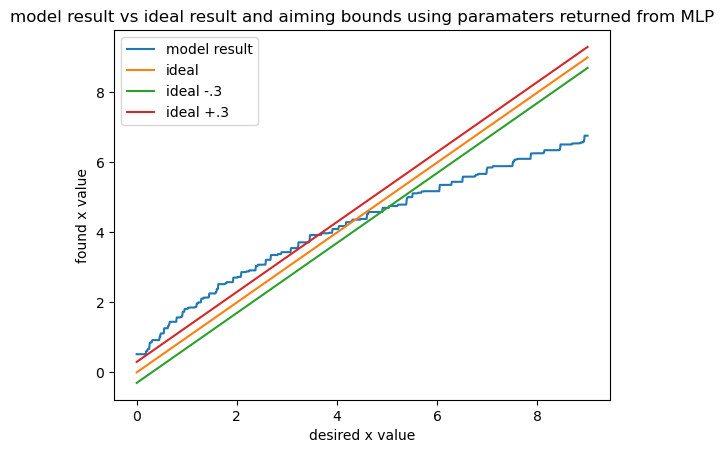

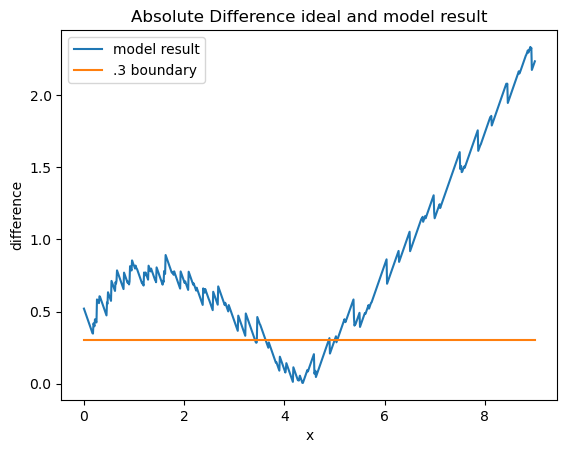

In [516]:
x_requested = np.linspace(0,9,901)
x_requested_lower_bound = np.linspace(0,9,901)-.3
x_requested_upper_bound = np.linspace(0,9,901)+.3
x_received = np.zeros(len(x_requested))
for t in np.arange(len(x_requested)):
    prediction = regr2.predict([[x_requested[t]]])[0]
    x_received[t] = get_x(prediction[0],prediction[1],prediction[2])
plt.plot(x_requested, x_received)
plt.plot(x_requested, x_requested)
plt.plot(x_requested, x_requested_lower_bound)
plt.plot(x_requested, x_requested_upper_bound)
plt.legend(['model result', 'ideal', 'ideal -.3', 'ideal +.3'])
plt.title("model result vs ideal result and aiming bounds using paramaters returned from MLP")
plt.xlabel("desired x value")
plt.ylabel("found x value")
plt.show()
plt.title("Absolute Difference ideal and model result")
plt.xlabel("x")
plt.ylabel("difference")
plt.plot(x_requested, np.abs(x_received-x_requested))
plt.plot(x_requested, np.ones(len(x_requested))*.3)
plt.legend(['model result', '.3 boundary'])
plt.show()

In [333]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [332]:
model = Sequential()
model.add(Dense(16, input_shape=(1,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
model.fit(np.array(X), np.array(y), epochs=5, batch_size=1, verbose=1, validation_split=0.2)

Epoch 1/5
103879/103879 [==============================] - 138s 1ms/step - loss: 2078.0662 - mean_squared_error: 16484223.0000 - val_loss: 2167.7883 - val_mean_squared_error: 17346770.0000
Epoch 2/5
103879/103879 [==============================] - 134s 1ms/step - loss: 2077.6814 - mean_squared_error: 16481629.0000 - val_loss: 2167.5952 - val_mean_squared_error: 17341950.0000
Epoch 3/5
103879/103879 [==============================] - 143s 1ms/step - loss: 2077.6819 - mean_squared_error: 16481896.0000 - val_loss: 2167.5344 - val_mean_squared_error: 17342304.0000
Epoch 4/5
103879/103879 [==============================] - 141s 1ms/step - loss: 2077.6746 - mean_squared_error: 16481926.0000 - val_loss: 2167.3931 - val_mean_squared_error: 17340178.0000
Epoch 5/5
103879/103879 [==============================] - 137s 1ms/step - loss: 2077.6790 - mean_squared_error: 16482097.0000 - val_loss: 2165.8894 - val_mean_squared_error: 17332242.0000


In [334]:
utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
812/812 - 1s - loss: 2091.6814 - mean_squared_error: 16582470.0000 - 712ms/epoch - 877us/step
Test loss: 2091.681396484375
Test accuracy: 16582470.0


In [315]:
# Define the input placeholder
x = tf.keras.Input(shape=(), dtype=tf.float32)

# Define the model layers
v = tf.keras.layers.Dense(1, activation="relu")(x)
w = tf.keras.layers.Dense(1, activation="tanh")(x)
theta = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Combine the outputs into a tuple
output = (v, w, theta)

# Create the model
model = tf.keras.Model(inputs=x, outputs=output)

# Define the loss function (mean squared error for each output)
loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

# Choose an optimizer (Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the model with loss and optimizer
model.compile(loss=loss_fn, optimizer=optimizer)

# Sample training data (modify this with your actual data)
x_train = tf.constant([1.0, 2.0, 3.0])
y_train = tf.constant([(2.0, 1.0, 0.5), (3.5, 2.0, 0.7), (5.0, 3.0, 0.8)])

# Train the model for a few epochs (increase epochs for better results)
model.fit(x_train, y_train, epochs=2)

# Example usage
example_input = 5.0

# Run the model with the example input
predictions = model(example_input)

# Access the individual predictions
v_pred, w_pred, theta_pred = predictions

# Print the predictions
print(f"Input: {example_input}")
print(f"v: {v_pred.numpy()}")
print(f"w: {w_pred.numpy()}")
print(f"theta: {theta_pred.numpy()}")

ValueError: Input 0 of layer "dense_20" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

In [177]:
def find_closest_tuple(target_value, sorted_data, y = -1, y_search_range = 50):
    lo = 0
    hi = len(sorted_data) - 1

    while lo < hi:
        mid = (lo + hi) // 2
        if sorted_data[mid][3] < target_value:
            lo = mid + 1
        else:
            hi = mid
    
    if y != -1:
#         print(np.abs(np.array(sorted_data[int(np.max([0,lo-50])):int(np.min([len(sorted_data),lo+50]))])[:,4]-1))
#         print(np.abs(np.array(sorted_data[int(np.max([0,lo-50])):int(np.min([len(sorted_data),lo+50]))])[:,4]))
#         print(np.abs(np.array(sorted_data[int(np.max([0,lo-50])):int(np.min([len(sorted_data),lo+50]))])[:,4]-1))
        print(int(np.max([0,lo-y_search_range])),int(np.min([len(sorted_data),lo+50])))
        lo =np.max([0,lo-y_search_range])+np.argmin(np.abs(np.array(sorted_data[int(np.max([0,lo-y_search_range])):int(np.min([len(sorted_data),lo+y_search_range]))])[:,4]-y))
        print(sorted_data[lo])
    # Now 'lo' points to the index where the closest or equal value is found
    else:
        closest_tuple = sorted_data[lo]
        if lo > 0 and abs(sorted_data[lo - 1][3] - target_value) < abs(closest_tuple[3] - target_value):
            closest_tuple = sorted_data[lo - 1] 
    closest_tuple = sorted_data[lo]

    # Check if the previous element is closer

    return closest_tuple

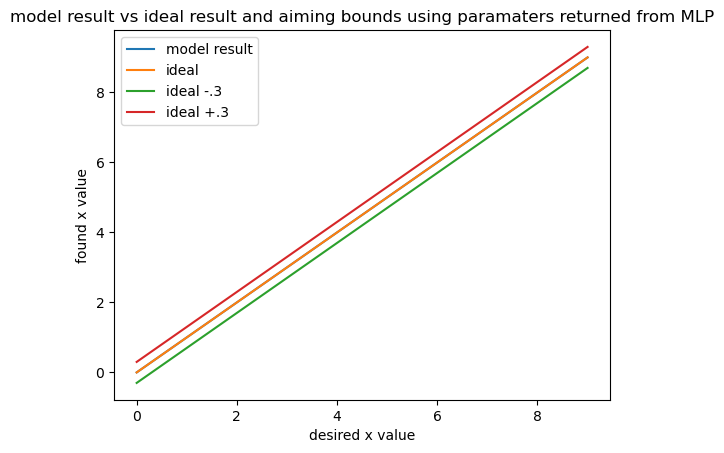

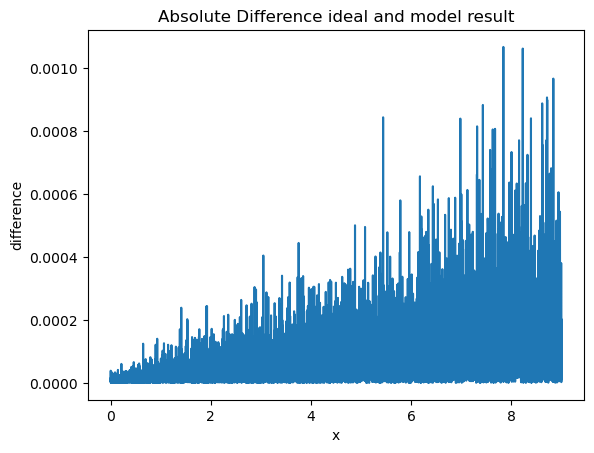

In [160]:
x_requested = np.linspace(0,9,9001)
x_requested_lower_bound = np.linspace(0,9,9001)-.3
x_requested_upper_bound = np.linspace(0,9,9001)+.3
x_received = np.zeros(len(x_requested))
for t in np.arange(len(x_requested)):
    x_received[t] = find_closest_tuple(x_requested[t], data_set_4)[3]
plt.plot(x_requested, x_received)
plt.plot(x_requested, x_requested)
plt.plot(x_requested, x_requested_lower_bound)
plt.plot(x_requested, x_requested_upper_bound)
plt.legend(['model result', 'ideal', 'ideal -.3', 'ideal +.3'])
plt.title("model result vs ideal result and aiming bounds using paramaters returned from MLP")
plt.xlabel("desired x value")
plt.ylabel("found x value")
plt.show()
plt.title("Absolute Difference ideal and model result")
plt.xlabel("x")
plt.ylabel("difference")
plt.plot(x_requested, np.abs(x_received-x_requested))
plt.show()

# Look at ball trajectories

0 50
(1.3998801206980709, 11943.296256678721, 89.74320346242101, 0.00892298097932126, 0.49988690306295697, 0.004442559335838113)
(1.3998801206980709, 11943.296256678721, 89.74320346242101, 0.00892298097932126, 0.49988690306295697, 0.004442559335838113)


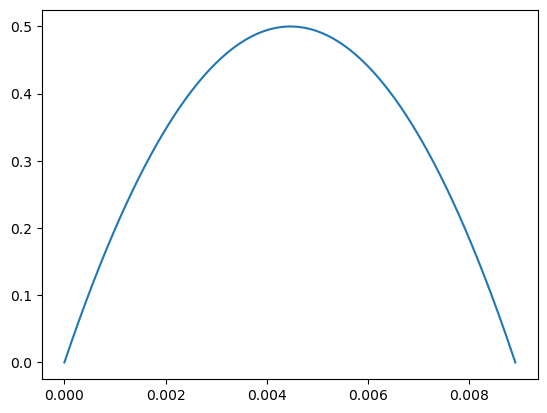

11704 13754
(1.4020858170359134, 5833.515273025723, 87.18467952048408, 0.09738188802214279, 0.5002614979450635, 0.04862456714821235)
(1.4020858170359134, 5833.515273025723, 87.18467952048408, 0.09738188802214279, 0.5002614979450635, 0.04862456714821235)


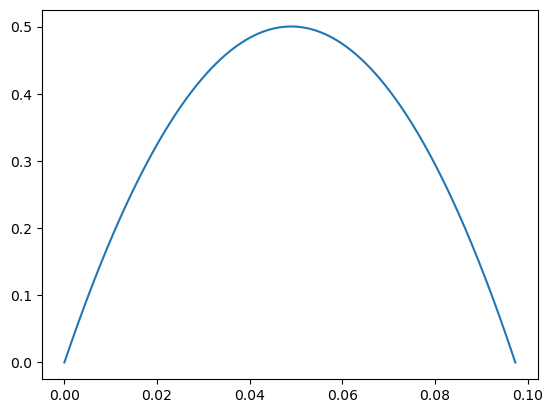

48927 50977
(1.4437082249870234, 6739.209365195758, 75.8271094661932, 0.5006113644738435, 0.4998156456382412, 0.2497750788232511)
(1.4437082249870234, 6739.209365195758, 75.8271094661932, 0.5006113644738435, 0.4998156456382412, 0.2497750788232511)


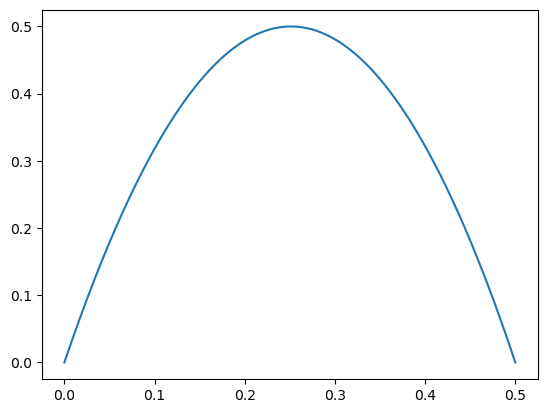

74493 76543
(1.5604742192222258, 3558.6043205213123, 63.784613576728894, 0.9678832869638722, 0.4999757069170147, 0.48502347163642684)
(1.5604742192222258, 3558.6043205213123, 63.784613576728894, 0.9678832869638722, 0.4999757069170147, 0.48502347163642684)


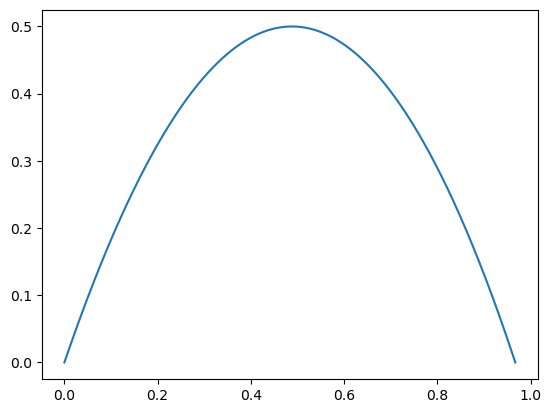

107084 109134
(2.000456768404024, 285.2306117627292, 62.00669608179004, 1.977683543975235, 0.8016346359952732, 0.7580850093130179)
(2.000456768404024, 285.2306117627292, 62.00669608179004, 1.977683543975235, 0.8016346359952732, 0.7580850093130179)


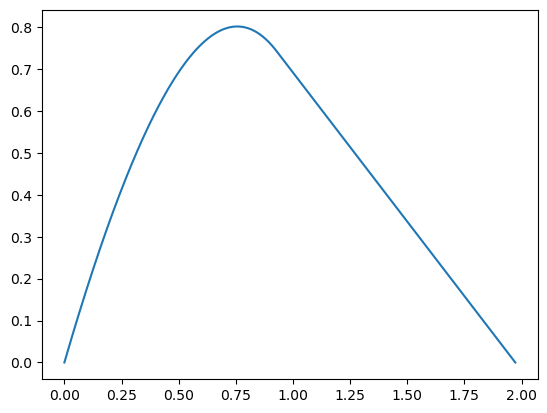

129524 131574
(2.2419932517074392, 296.1403731138148, 62.19194761177383, 2.962997875413629, 1.0111449465645057, 0.9393768129989707)
(2.2419932517074392, 296.1403731138148, 62.19194761177383, 2.962997875413629, 1.0111449465645057, 0.9393768129989707)


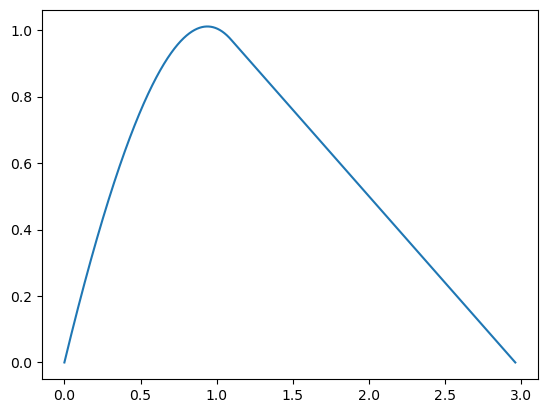

146813 148863
(2.397413250068836, 303.48066263642346, 61.9689863187745, 3.893087270724431, 1.1521844487754735, 1.0766614237209324)
(2.397413250068836, 303.48066263642346, 61.9689863187745, 3.893087270724431, 1.1521844487754735, 1.0766614237209324)


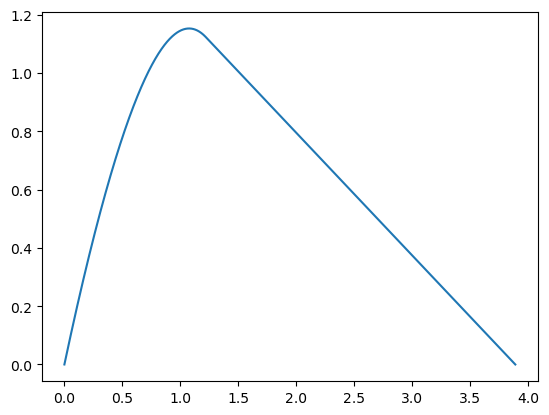

160377 162427
(2.853318826511364, 373.24655887345284, 61.93957366238029, 4.93504661409603, 1.6305073225387974, 1.5344966419355877)
(2.853318826511364, 373.24655887345284, 61.93957366238029, 4.93504661409603, 1.6305073225387974, 1.5344966419355877)


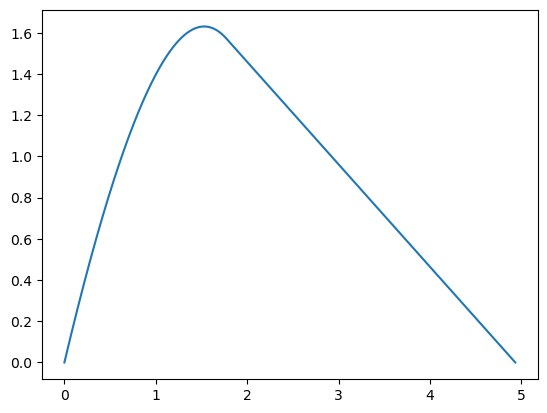

171455 173505
(3.1461381459096716, 416.13475205453955, 64.83635047454761, 5.808763080547543, 2.0819333074623305, 1.7163341394240907)
(3.1461381459096716, 416.13475205453955, 64.83635047454761, 5.808763080547543, 2.0819333074623305, 1.7163341394240907)


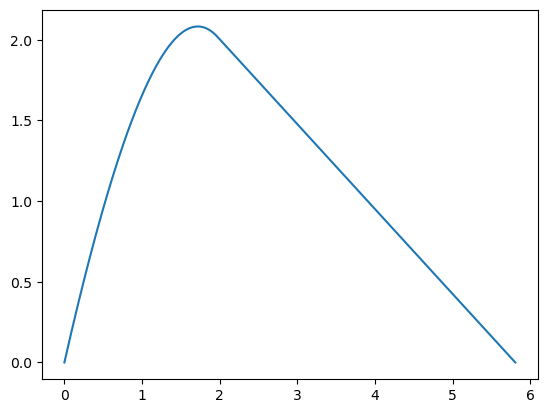

180758 182808
(3.172392826326626, 395.63017725014583, 61.75140696026123, 7.204216250006946, 2.0099573585286694, 1.8929617946245016)
(3.172392826326626, 395.63017725014583, 61.75140696026123, 7.204216250006946, 2.0099573585286694, 1.8929617946245016)


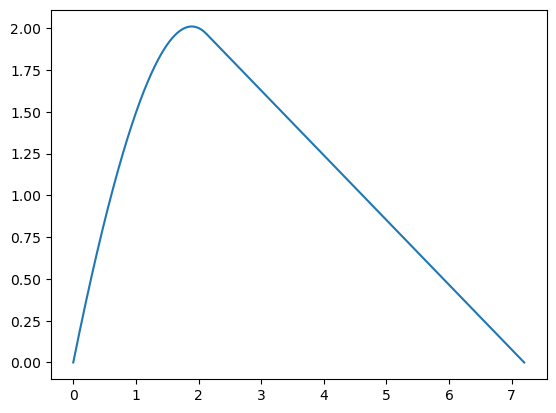

188604 190654
(3.6042740456930797, 467.3379314872097, 65.20957797941823, 8.17829656088698, 2.749066028130005, 2.2253228929991264)
(3.6042740456930797, 467.3379314872097, 65.20957797941823, 8.17829656088698, 2.749066028130005, 2.2253228929991264)


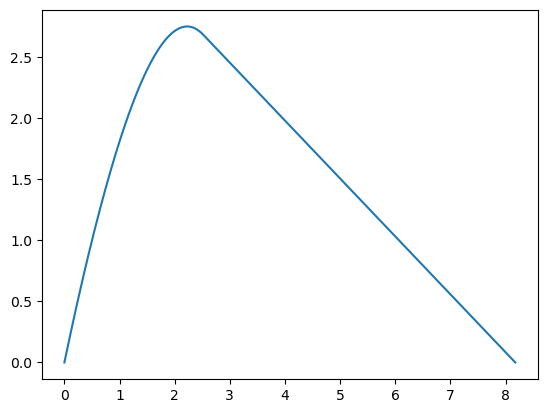

In [196]:
x_values = np.array([0,.1,.5,1,2,3,4,5,6,7,8])
for x in x_values:
    received_paramaters = find_closest_tuple(x, data_set_4,.5,2000)
    print(received_paramaters)
    x_points, y_points = get_trajectory(received_paramaters[0],received_paramaters[1],received_paramaters[2],0.00001,500000000)
    plt.plot(x_points, y_points)
#     plt.plot(x_points[0::10],y_points[0::10],'o')
    plt.show()